In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt
import random
import numpy as np
import pandas as pd
import os

print(tf.__version__)

2.8.0


In [ ]:
root = 'data/train/'
files = os.listdir(root)
types = [filename.split('.')[0] for filename in files]

df = pd.DataFrame({
    'file': files,
    'type': types
})

df.head()

,file,type
0,cat.8504.jpg,cat
1,cat.11631.jpg,cat
2,cat.2293.jpg,cat
3,dog.10835.jpg,dog
4,cat.1794.jpg,cat


Image shape: (219, 199)


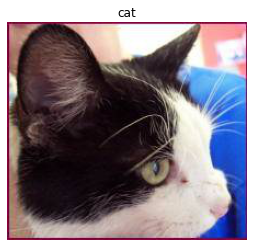

In [ ]:
from tensorflow.keras.preprocessing.image import load_img

index = random.randint(0, len(files))
img = load_img(root + files[index])
plt.imshow(img)
plt.axis("off")
plt.title(types[index])
print(f"Image shape: {img.size}")

In [ ]:
from sklearn.model_selection import train_test_split
train, validation = train_test_split(df, test_size=0.2, random_state=42)
print(f"train: {len(train)}, vaildation: {len(validation)}")

train: 20000, vaildation: 5000


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen_train = ImageDataGenerator(rescale=1/255.,
                             rotation_range=20,
                             width_shift_range=0.2,
                             height_shift_range=0.2,
                             zoom_range=0.2,
                             shear_range=0.2,
                             horizontal_flip=True,
                             vertical_flip=True)
datagen_valid = ImageDataGenerator(rescale=1/255.)

generator_train = datagen_train.flow_from_dataframe(train, root, x_col='file',
                                                    y_col='type', target_size=(224, 224),
                                                    class_mode='categorical', batch_size=32)
generator_valid = datagen_valid.flow_from_dataframe(validation, root, x_col='file',
                                                    y_col='type', target_size=(224, 224),
                                                    class_mode='categorical', batch_size=32)

Found 20000 validated image filenames belonging to 2 classes.
Found 5000 validated image filenames belonging to 2 classes.


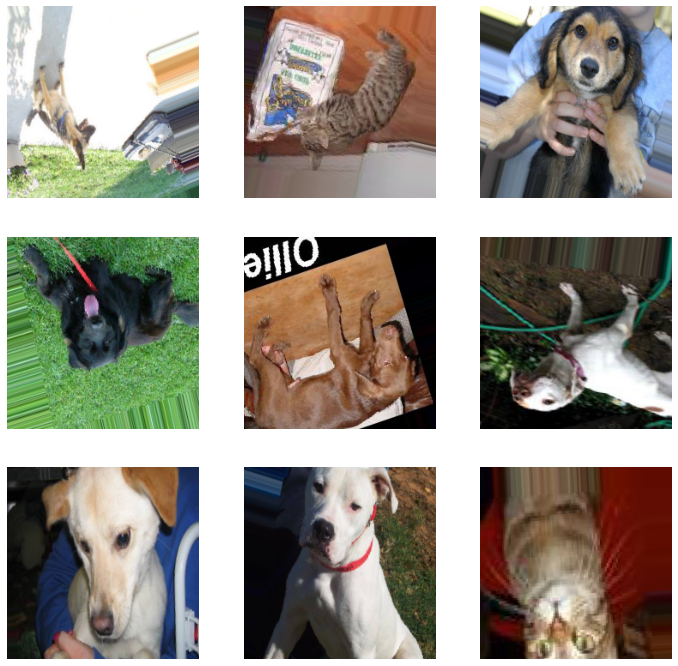

In [ ]:
plt.figure(figsize=(12, 12))
for i in range(9):
    plt.subplot(3, 3, i+1)
    x, y = next(generator_train)
    image = x[0]
#   plt.title(y[0])
    plt.imshow(image)
    plt.axis("off")
plt.show()

## Tools

In [ ]:
results_cols = ['Model', 'loss', 'accuracy']
results = pd.DataFrame(columns=results_cols)

In [ ]:
import math


K = tf.keras.backend

class ExponentialLearningRate(tf.keras.callbacks.Callback):
    def __init__(self, factor):
        self.factor = factor
        self.rates = []
        self.losses = []
    def on_batch_end(self, batch, logs):
        self.rates.append(K.get_value(self.model.optimizer.learning_rate))
        self.losses.append(logs["loss"])
        K.set_value(self.model.optimizer.learning_rate, self.model.optimizer.learning_rate * self.factor)


def find_learning_rate(model, data, epochs=1, batch_size=32, min_rate=10**-5, max_rate=10):
    init_weights = model.get_weights()
    iterations = math.ceil(data.samples / batch_size) * epochs
    factor = np.exp(np.log(max_rate / min_rate) / iterations)
    init_lr = K.get_value(model.optimizer.learning_rate)
    K.set_value(model.optimizer.learning_rate, min_rate)
    exp_lr = ExponentialLearningRate(factor)
    history = model.fit(data, epochs=epochs, batch_size=batch_size,
                        callbacks=[exp_lr])
    K.set_value(model.optimizer.learning_rate, init_lr)
    model.set_weights(init_weights)
    return exp_lr.rates, exp_lr.losses

def plot_lr_vs_loss(rates, losses):
    plt.plot(rates, losses)
    plt.gca().set_xscale('log')
    plt.hlines(min(losses), min(rates), max(rates))
    plt.axis([min(rates), max(rates), min(losses), (losses[0] + min(losses)) / 2])
    plt.xlabel("Learning rate")
    plt.ylabel("Loss")

In [ ]:
def calc_lr(model, opt, data, batch_size=32):
  model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
  
  rates, losses = find_learning_rate(model, data, epochs=1, batch_size=batch_size)
  plot_lr_vs_loss(rates, losses)
  plt.axis([min(rates), max(rates), min(losses), (losses[0] + min(losses)) / 1.4])

In [ ]:
def custom_fit(model, opt, train, validation, batch_size=32, name=""):
  early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)
  checkpoint_cb = tf.keras.callbacks.ModelCheckpoint("model" + name + ".h5", save_best_only=True)

  model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
  history = model.fit(train, epochs=10, validation_data=validation,
            steps_per_epoch=train.samples / batch_size,
            callbacks=[early_stopping_cb, checkpoint_cb])
  return history

## Baseline model

In [42]:
model = tf.keras.models.Sequential([                     
        tf.keras.layers.Conv2D(filters=64, kernel_size=(7, 7), strides=(1, 1),
                               activation='elu', kernel_initializer='he_normal',
                               padding='same', input_shape=[224, 224, 3]),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Conv2D(filters=64, kernel_size=(7, 7), strides=(2, 2),
                               activation='elu', kernel_initializer='he_normal',
                               padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D(pool_size=(2, 2)),
        tf.keras.layers.Conv2D(filters=128, kernel_size=(3, 3), strides=(1, 1),
                               activation='elu', kernel_initializer='he_normal'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Conv2D(filters=128, kernel_size=(3, 3), strides=(2, 2),
                               activation='elu', kernel_initializer='he_normal'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.GlobalMaxPool2D(),
        tf.keras.layers.Dropout(0.25),
        tf.keras.layers.Dense(50, activation='elu', kernel_initializer='he_normal'),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(2, activation='softmax')
])

625/625 [==============================] - 290s 463ms/step - loss: 34441.1367 - accuracy: 0.5066


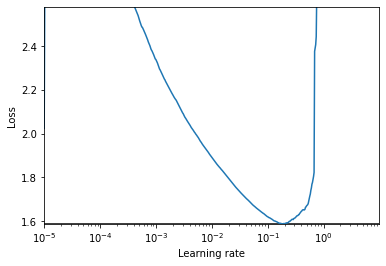

In [ ]:
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
calc_lr(model, optimizer, generator_train)

In [43]:
opt = tf.keras.optimizers.Adam(learning_rate=5e-3, decay=5e-3 / 200)
history = custom_fit(model, opt, generator_train, generator_valid)

Epoch 1/10
625/625 [==============================] - 329s 525ms/step - loss: 0.7609 - accuracy: 0.5297 - val_loss: 0.6709 - val_accuracy: 0.5750
Epoch 2/10
625/625 [==============================] - 315s 504ms/step - loss: 0.6803 - accuracy: 0.5677 - val_loss: 0.6419 - val_accuracy: 0.6370
Epoch 3/10
625/625 [==============================] - 308s 493ms/step - loss: 0.6649 - accuracy: 0.5944 - val_loss: 0.6525 - val_accuracy: 0.5894
Epoch 4/10
625/625 [==============================] - 306s 490ms/step - loss: 0.6617 - accuracy: 0.5995 - val_loss: 0.6375 - val_accuracy: 0.6180
Epoch 5/10
625/625 [==============================] - 308s 492ms/step - loss: 0.6528 - accuracy: 0.6173 - val_loss: 0.6683 - val_accuracy: 0.5982
Epoch 6/10
625/625 [==============================] - 309s 494ms/step - loss: 0.6278 - accuracy: 0.6490 - val_loss: 0.6217 - val_accuracy: 0.6484
Epoch 7/10
625/625 [==============================] - 304s 486ms/step - loss: 0.6095 - accuracy: 0.6704 - val_loss: 0.6015 -

In [44]:
loss, accuracy = model.evaluate(generator_valid)
results.loc[0, 'Model'] = 'Base line model'
results.loc[0, 'loss'] = loss
results.loc[0, 'accuracy'] = accuracy

157/157 [==============================] - 18s 116ms/step - loss: 0.5131 - accuracy: 0.7482


## VGG16

In [ ]:
vgg16_model = tf.keras.applications.vgg16.VGG16(input_shape=(224, 244, 3), include_top=False, weights='imagenet')

for layer in vgg16_model.layers[:-5]:
    layer.trainable = False

In [ ]:
model_vgg = tf.keras.models.Sequential([
    vgg16_model,
    tf.keras.layers.GlobalMaxPooling2D(),
    tf.keras.layers.Dropout(0.15),
    tf.keras.layers.Dense(256, activation='elu', kernel_initializer='he_normal'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(128, activation='elu', kernel_initializer='he_normal'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(2, activation='softmax')                                    
])

In [ ]:
datagen_train_vgg = ImageDataGenerator(rotation_range=20,
                             width_shift_range=0.2,
                             height_shift_range=0.2,
                             zoom_range=0.2,
                             shear_range=0.2,
                             horizontal_flip=True,
                             vertical_flip=True, 
                             preprocessing_function=tf.keras.applications.vgg16.preprocess_input)
datagen_valid_vgg = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input)

generator_train_vgg = datagen_train_vgg.flow_from_dataframe(train, root, x_col='file',
                                                    y_col='type', target_size=(224, 224),
                                                    class_mode='categorical', batch_size=32)
generator_valid_vgg = datagen_valid_vgg.flow_from_dataframe(validation, root, x_col='file',
                                                    y_col='type', target_size=(224, 224),
                                                    class_mode='categorical', batch_size=32)

Found 20000 validated image filenames belonging to 2 classes.
Found 5000 validated image filenames belonging to 2 classes.


625/625 [==============================] - 280s 446ms/step - loss: 1274744406016.0000 - accuracy: 0.5562


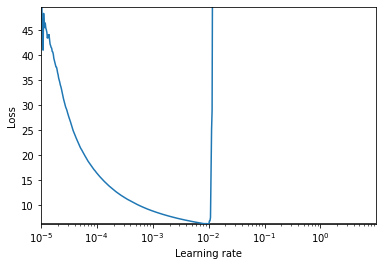

In [ ]:
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
calc_lr(model_vgg, optimizer, generator_train_vgg)

In [ ]:
opt = tf.keras.optimizers.Adam(learning_rate=1e-4, decay=1e-4 / 200)
history_vgg = custom_fit(model_vgg, opt, generator_train_vgg, generator_valid_vgg, name='_vgg')

Epoch 1/10
625/625 [==============================] - 312s 498ms/step - loss: 1.2717 - accuracy: 0.7529 - val_loss: 0.1825 - val_accuracy: 0.9452
Epoch 2/10
625/625 [==============================] - 309s 494ms/step - loss: 0.3685 - accuracy: 0.8528 - val_loss: 0.1245 - val_accuracy: 0.9610
Epoch 3/10
625/625 [==============================] - 306s 490ms/step - loss: 0.3086 - accuracy: 0.8773 - val_loss: 0.1093 - val_accuracy: 0.9600
Epoch 4/10
625/625 [==============================] - 309s 494ms/step - loss: 0.2364 - accuracy: 0.9086 - val_loss: 0.1019 - val_accuracy: 0.9660
Epoch 5/10
625/625 [==============================] - 308s 492ms/step - loss: 0.1884 - accuracy: 0.9270 - val_loss: 0.0941 - val_accuracy: 0.9674
Epoch 6/10
625/625 [==============================] - 305s 488ms/step - loss: 0.1719 - accuracy: 0.9360 - val_loss: 0.0913 - val_accuracy: 0.9714
Epoch 7/10
625/625 [==============================] - 305s 487ms/step - loss: 0.1648 - accuracy: 0.9384 - val_loss: 0.0806 -

In [ ]:
loss, accuracy = model_vgg.evaluate(generator_valid_vgg)
results.loc[1, 'Model'] = 'VGG 16'
results.loc[1, 'loss'] = loss
results.loc[1, 'accuracy'] = accuracy

157/157 [==============================] - 26s 167ms/step - loss: 0.1147 - accuracy: 0.9570


## ResNet

In [ ]:
resnet_model = tf.keras.applications.resnet50.ResNet50(input_shape=(224, 244, 3), include_top=False, weights='imagenet')

for layer in resnet_model.layers[:-5]:
    layer.trainable = False

In [ ]:
model_resnet = tf.keras.models.Sequential([
    resnet_model,
    tf.keras.layers.GlobalMaxPooling2D(),
    tf.keras.layers.Dropout(0.15),
    tf.keras.layers.Dense(256, activation='elu', kernel_initializer='he_normal'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(128, activation='elu', kernel_initializer='he_normal'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(2, activation='softmax')                                    
])

In [ ]:
datagen_train_resnet = ImageDataGenerator(rotation_range=20,
                             width_shift_range=0.2,
                             height_shift_range=0.2,
                             zoom_range=0.2,
                             shear_range=0.2,
                             horizontal_flip=True,
                             vertical_flip=True, 
                             preprocessing_function=tf.keras.applications.resnet50.preprocess_input)
datagen_valid_resnet = ImageDataGenerator(preprocessing_function=tf.keras.applications.resnet50.preprocess_input)

generator_train_resnet = datagen_train_resnet.flow_from_dataframe(train, root, x_col='file',
                                                    y_col='type', target_size=(224, 224),
                                                    class_mode='categorical', batch_size=32)
generator_valid_resnet = datagen_valid_resnet.flow_from_dataframe(validation, root, x_col='file',
                                                    y_col='type', target_size=(224, 224),
                                                    class_mode='categorical', batch_size=32)

Found 20000 validated image filenames belonging to 2 classes.
Found 5000 validated image filenames belonging to 2 classes.


625/625 [==============================] - 265s 419ms/step - loss: 4538.6714 - accuracy: 0.6647


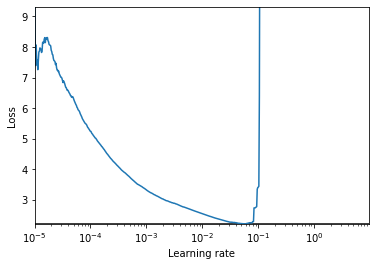

In [ ]:
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
calc_lr(model_resnet, optimizer, generator_train_resnet)

In [ ]:
opt = tf.keras.optimizers.Adam(learning_rate=5e-4, decay=5e-4 / 200)
history_resnet = custom_fit(model_resnet, opt, generator_train_resnet, generator_valid_resnet, name='_resnet')

Epoch 1/10
625/625 [==============================] - 296s 470ms/step - loss: 0.6127 - accuracy: 0.8921 - val_loss: 0.0689 - val_accuracy: 0.9722
Epoch 2/10
625/625 [==============================] - 283s 452ms/step - loss: 0.2127 - accuracy: 0.9245 - val_loss: 0.0585 - val_accuracy: 0.9786
Epoch 3/10
625/625 [==============================] - 281s 450ms/step - loss: 0.1533 - accuracy: 0.9431 - val_loss: 0.0463 - val_accuracy: 0.9802
Epoch 4/10
625/625 [==============================] - 281s 449ms/step - loss: 0.1333 - accuracy: 0.9450 - val_loss: 0.0493 - val_accuracy: 0.9796
Epoch 5/10
625/625 [==============================] - 280s 448ms/step - loss: 0.1208 - accuracy: 0.9513 - val_loss: 0.0642 - val_accuracy: 0.9764
Epoch 6/10
625/625 [==============================] - 281s 449ms/step - loss: 0.1091 - accuracy: 0.9566 - val_loss: 0.0520 - val_accuracy: 0.9788
Epoch 7/10
625/625 [==============================] - 281s 450ms/step - loss: 0.1005 - accuracy: 0.9612 - val_loss: 0.0476 -

In [ ]:
loss, accuracy = model_resnet.evaluate(generator_valid_resnet)
results.loc[2, 'Model'] = 'ResNet50'
results.loc[2, 'loss'] = loss
results.loc[2, 'accuracy'] = accuracy

157/157 [==============================] - 29s 183ms/step - loss: 0.0382 - accuracy: 0.9840


## Model selection and evaluation

In [45]:
results

,Model,loss,accuracy
0,Base line model,0.513106,0.7482
1,VGG 16,0.114728,0.957
2,ResNet50,0.038187,0.984


In [ ]:
model_resnet.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 7, 8, 2048)        23587712  
                                                                 
 global_max_pooling2d_4 (Glo  (None, 2048)             0         
 balMaxPooling2D)                                                
                                                                 
 dropout_11 (Dropout)        (None, 2048)              0         
                                                                 
 dense_11 (Dense)            (None, 256)               524544    
                                                                 
 dropout_12 (Dropout)        (None, 256)               0         
                                                                 
 dense_12 (Dense)            (None, 128)               32896     
                                                      

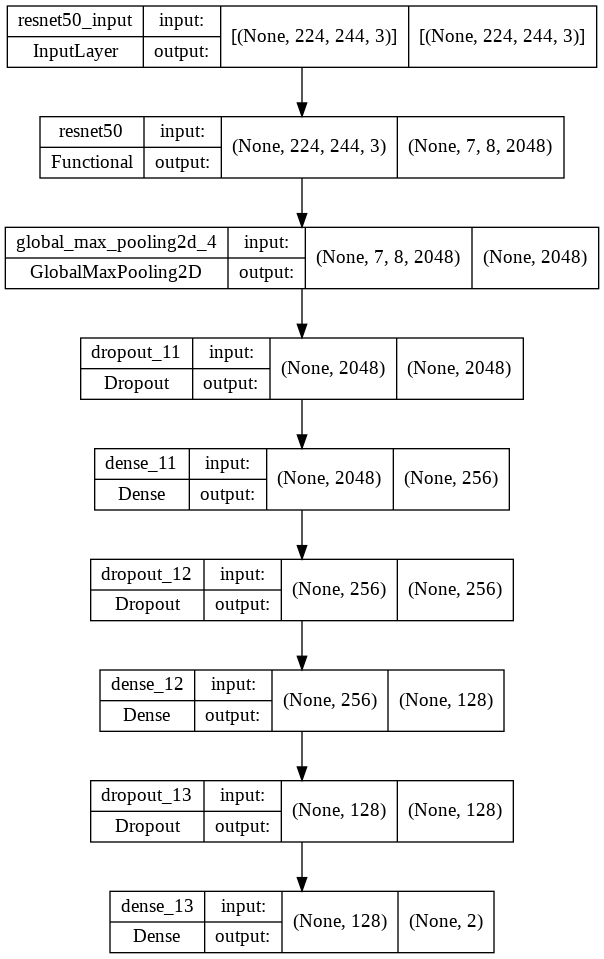

In [ ]:
from tensorflow.keras.utils import plot_model
from IPython.display import SVG, Image
plot_model(model_resnet, to_file='model.png', show_shapes=True, show_layer_names=True)
Image('model.png')

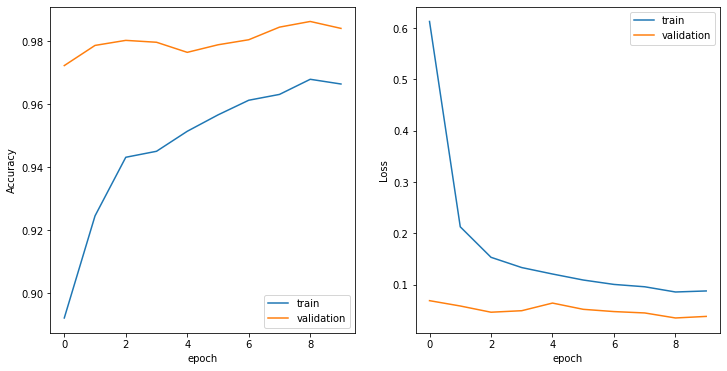

In [ ]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history_resnet.history['accuracy'])
plt.plot(history_resnet.history['val_accuracy'])
plt.ylabel('Accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'])

plt.subplot(1, 2, 2)
plt.plot(history_resnet.history['loss'])
plt.plot(history_resnet.history['val_loss'])
plt.ylabel('Loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'])

plt.show()